In [10]:
from tracr.rasp import rasp
from tracr.compiler import compiling
from tracr.compiler import lib

import sys
import os

module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from src.model import Model
from src.functions import *

In [11]:
def getFileNames(baseDirectory, modelName, setAndMetric, noiseType, fileParamName, paramValue, averageCount):
    fileNames = []
    for i in range(1,averageCount+1):
        fileNames.append(baseDirectory + modelName + setAndMetric + noiseType + fileParamName + str(paramValue) + "_" + str(i))
    return fileNames

#Merge the results from the files in list. The files need to have the same dimension
def loadArray(fileNames="temp"):
    if type(fileNames) is list and len(fileNames)==1:
        fileNames = fileNames[0]

    if type(fileNames) is list:
        file = open(fileNames[0], "rb")
        array = np.load(file).reshape((-1,1))
        file.close()
        for fn in fileNames[1:]:
            file = open(fn, "rb")
            conAcc = np.load(file).reshape((-1,1))
            array = np.concatenate((array, conAcc), axis=1)
            file.close()
        
    else:
        file = open(fileNames, "rb")
        array = np.load(file)
        file.close()

    return array

def plotData(ax, n_epochs, loss, stdMode):
    if np.ndim(loss) == 2:
        mean = np.mean(loss, axis=1)
        std = np.std(loss, axis=1)
    else:
        mean = loss
        std = np.zeros_like(loss)
    match stdMode:
        case "bar":
            ax.errorbar(np.linspace(0, n_epochs, len(mean)), mean, std, elinewidth=1.2, capsize=5, capthick=1.5)
        case "line":
            ax.plot(np.linspace(0, n_epochs, len(mean)), mean)
            ax.fill_between(np.linspace(0, n_epochs, len(mean)), mean-std, mean+std, alpha=.2)
        case _:
            ax.plot(np.linspace(0, n_epochs, len(mean)), mean)

In [12]:
#Assumes models are saved in standard format
def displayResults(baseDirectory, modelName, consideredParams = [0.01, 0.03, 0.05, 0.07, 0.09, 0.11] ,figsize=(14,6), n_epochs = 100000, 
                      combinePlots = False, useLogLoss = True, customTitle = None, noiseType = "gaussian", averageCount = 5, stdMode = "bar", clipEpochsAt = None):
    if stdMode and stdMode not in ["bar", "line"]:
        print("Error: Std mode needs to be None, 'bar' or 'line'")                                   
    if noiseType not in ["gaussian", "bitflip"]:
        print("Error: Noise type needs to be 'gaussian' or 'bitflip'")
        return -1
    
    paramName = "std"
    fileParamName = "_std"
    if noiseType == "bitflip":
        paramName = "Flip rate"
        fileParamName = "_fliprate"
    
    if clipEpochsAt:
        pass    #TODO

    f = 4   #Factor which avoids index of of bounds when combining plots
    if combinePlots:
        fig, axs = plt.subplots(1,2, figsize=figsize)
        f = 2
    else:
        if figsize == (14,6):
            figsize = (14,12)
        fig, axs = plt.subplots(2,2, figsize=figsize)
        axs = [axs[0][0], axs[0][1], axs[1][0], axs[1][1]] #Flatten

    legends = [[],[],[],[]]

    for p in consideredParams:
        #Training Loss
        legends[0].append("Training - " + paramName + " = "+str(p))
        fileNames = getFileNames(baseDirectory, modelName, "_train_loss_", noiseType, fileParamName, p, averageCount)
        loss = loadArray(fileNames)
        if useLogLoss:
            loss = np.log10(loss+1)
        plotData(axs[0], n_epochs, loss, stdMode)
        #Training Accuracy
        legends[1].append("Training - " + paramName + " = "+str(p))
        fileNames = getFileNames(baseDirectory, modelName, "_train_acc_", noiseType, fileParamName, p, averageCount)
        acc = loadArray(fileNames)
        plotData(axs[1], n_epochs, acc, stdMode)
        #Validation Loss
        legends[2%f].append("Validation - " + paramName + " = "+str(p))
        fileNames = getFileNames(baseDirectory, modelName, "_val_loss_", noiseType, fileParamName, p, averageCount)
        loss = loadArray(fileNames)
        if useLogLoss:
            loss = np.log10(loss+1)
        plotData(axs[2%f], n_epochs, loss, stdMode)
        #Validation Accuracy
        legends[3%f].append("Validation - " + paramName + " = "+str(p))
        fileNames = getFileNames(baseDirectory, modelName, "_val_acc_", noiseType, fileParamName, p, averageCount)
        acc = loadArray(fileNames)
        plotData(axs[3%f], n_epochs, acc, stdMode)

    if combinePlots:
        axs[0].set_title("Loss")
        if useLogLoss:
            axs[0].set(xlabel="Epochs", ylabel="Logarithmic Loss [log(loss+1)]")
        else:  
            axs[0].set(xlabel="Epochs", ylabel="Loss")
        axs[0].legend(legends[0]+legends[1]+legends[2]+legends[3])#
        axs[1].set_title("Accuracy")
        axs[1].set(xlabel="Epochs", ylabel="Accuracy")
        axs[1].legend(legends[0]+legends[1]+legends[2]+legends[3])
    else:
        axs[0].set_title("Training Loss")
        if useLogLoss:
            axs[0].set(xlabel="Epochs", ylabel="Logarithmic Loss [log(loss+1)]")
        else:  
            axs[0].set(xlabel="Epochs", ylabel="Loss")
        axs[0].legend(legends[0])
        axs[1].set_title("Training Accuracy")
        axs[1].set(xlabel="Epochs", ylabel="Accuracy")
        axs[1].legend(legends[1])
        axs[2].set_title("Validation Loss")
        if useLogLoss:
            axs[2].set(xlabel="Epochs", ylabel="Logarithmic Loss [log(loss+1)]")
        else:  
            axs[2].set(xlabel="Epochs", ylabel="Loss")
        axs[2].legend(legends[2])
        axs[3].set_title("Validation Accuracy")
        axs[3].set(xlabel="Epochs", ylabel="Accuracy")
        axs[3].legend(legends[3])
    if customTitle:
        fig.suptitle(customTitle)
    else:
        fig.suptitle(modelName)


    #Check that combine plots work correctly on overtraining

    #There are a shit ton of files. Consider compressing results into model/set/noiseModel files

### Displaying Gaussian noise results up till std 0.11

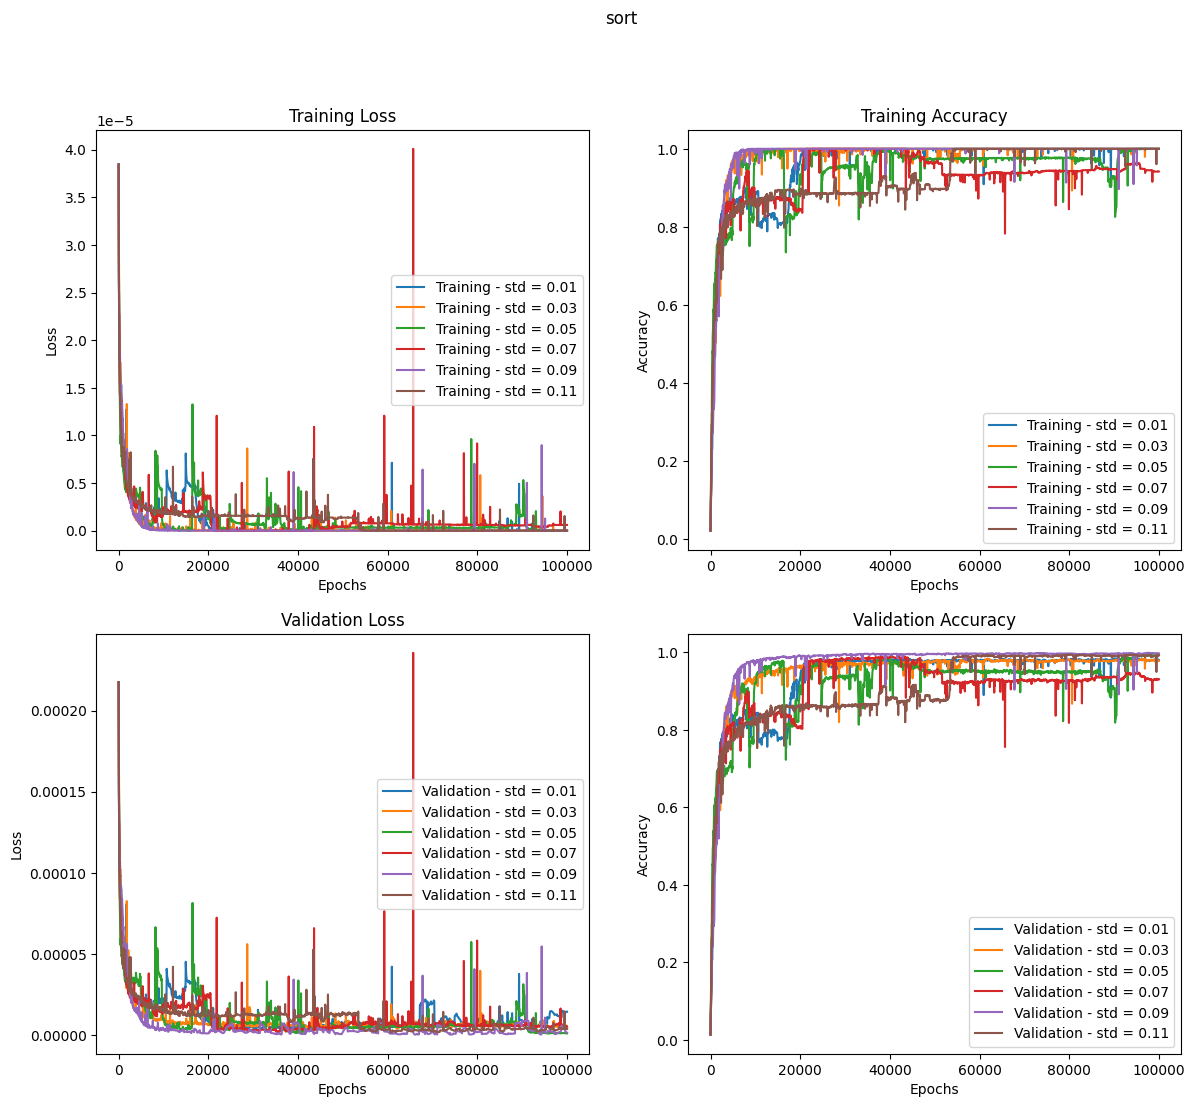

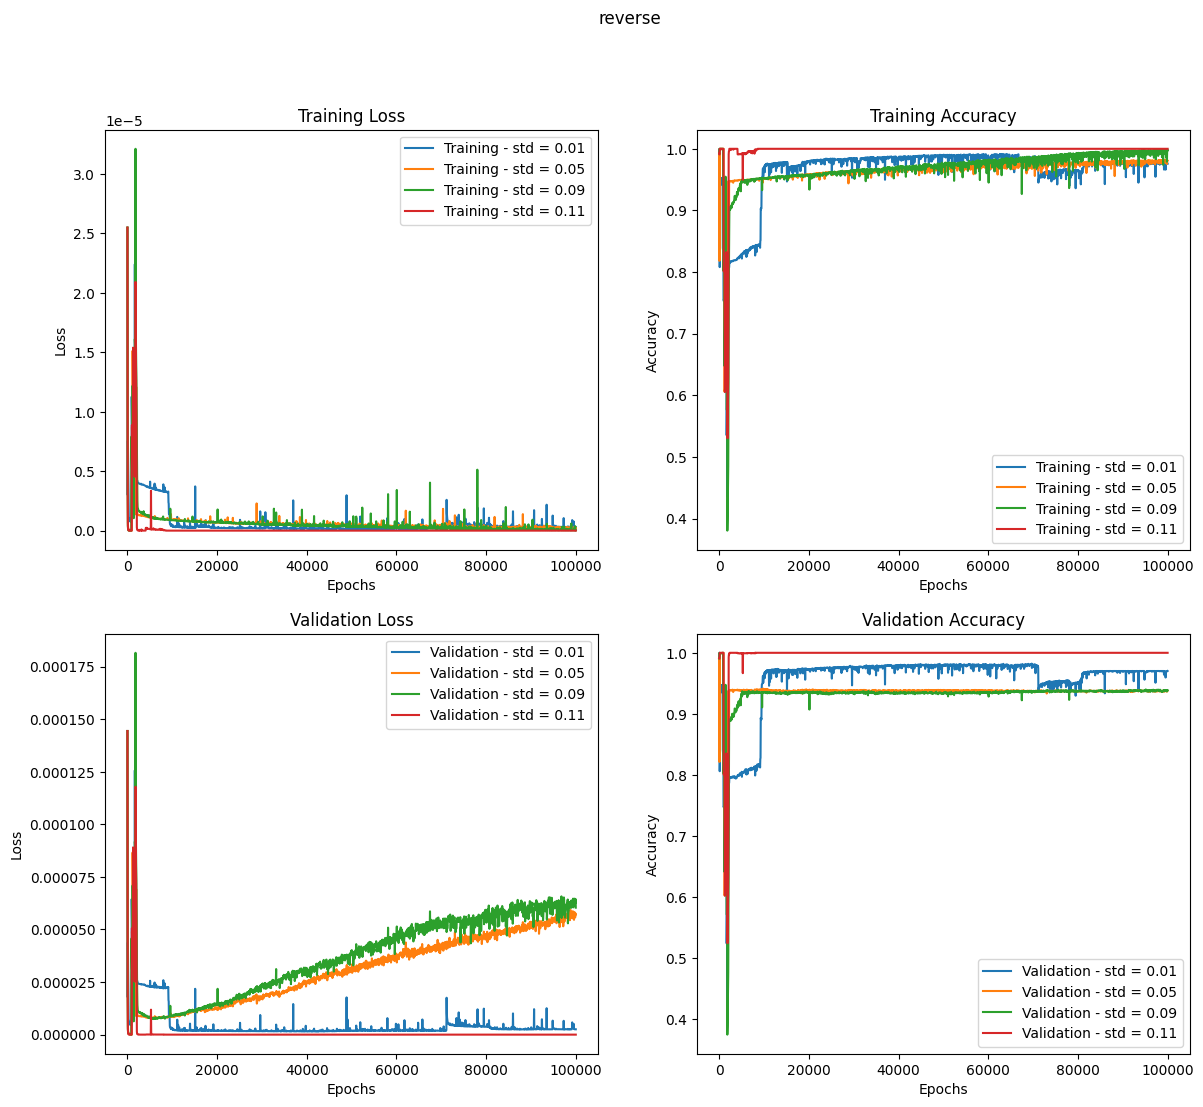

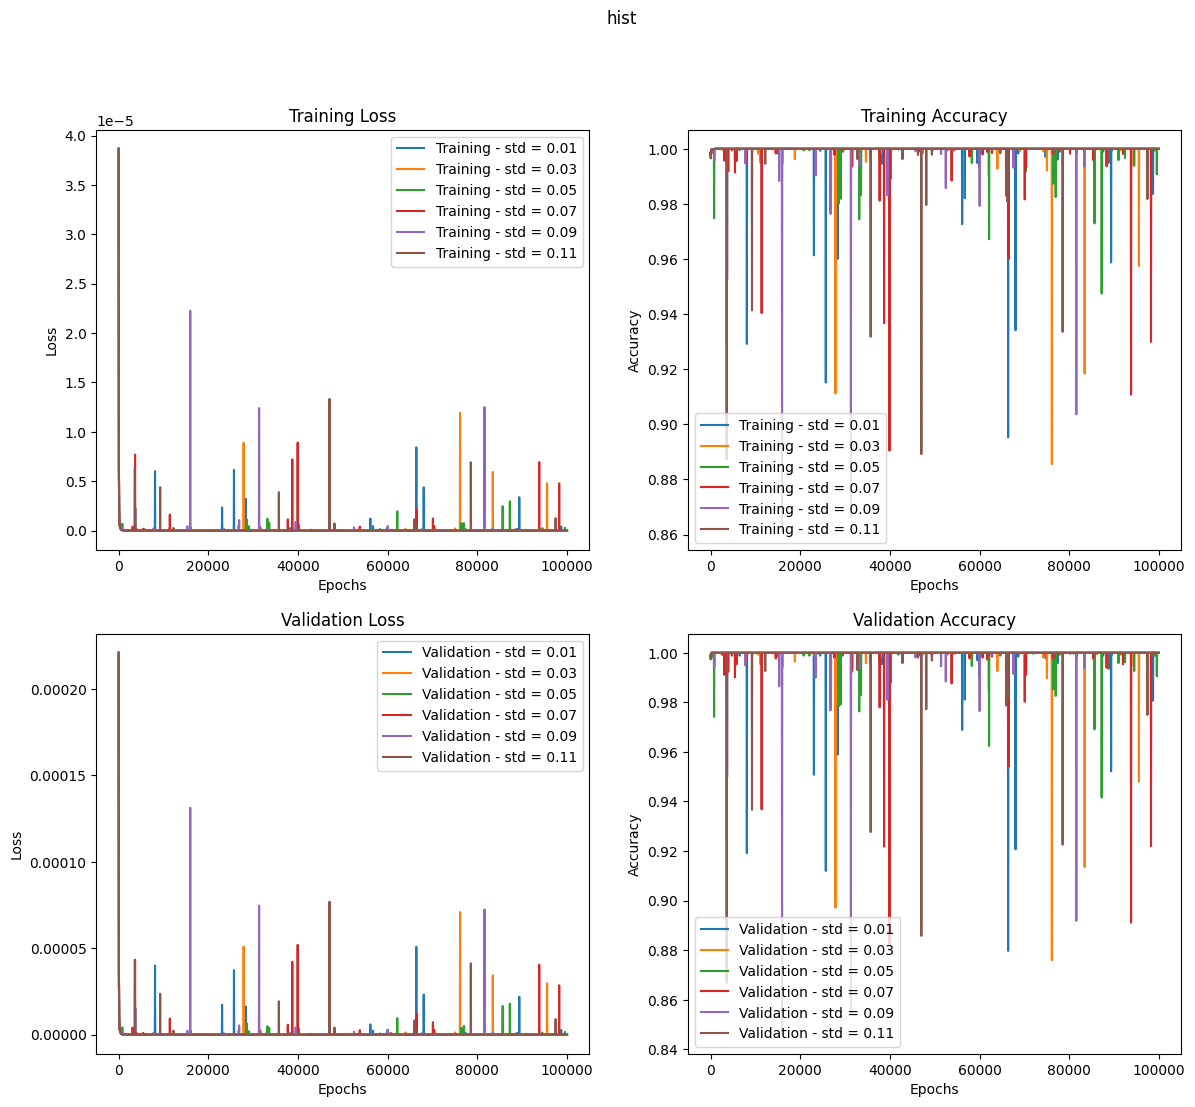

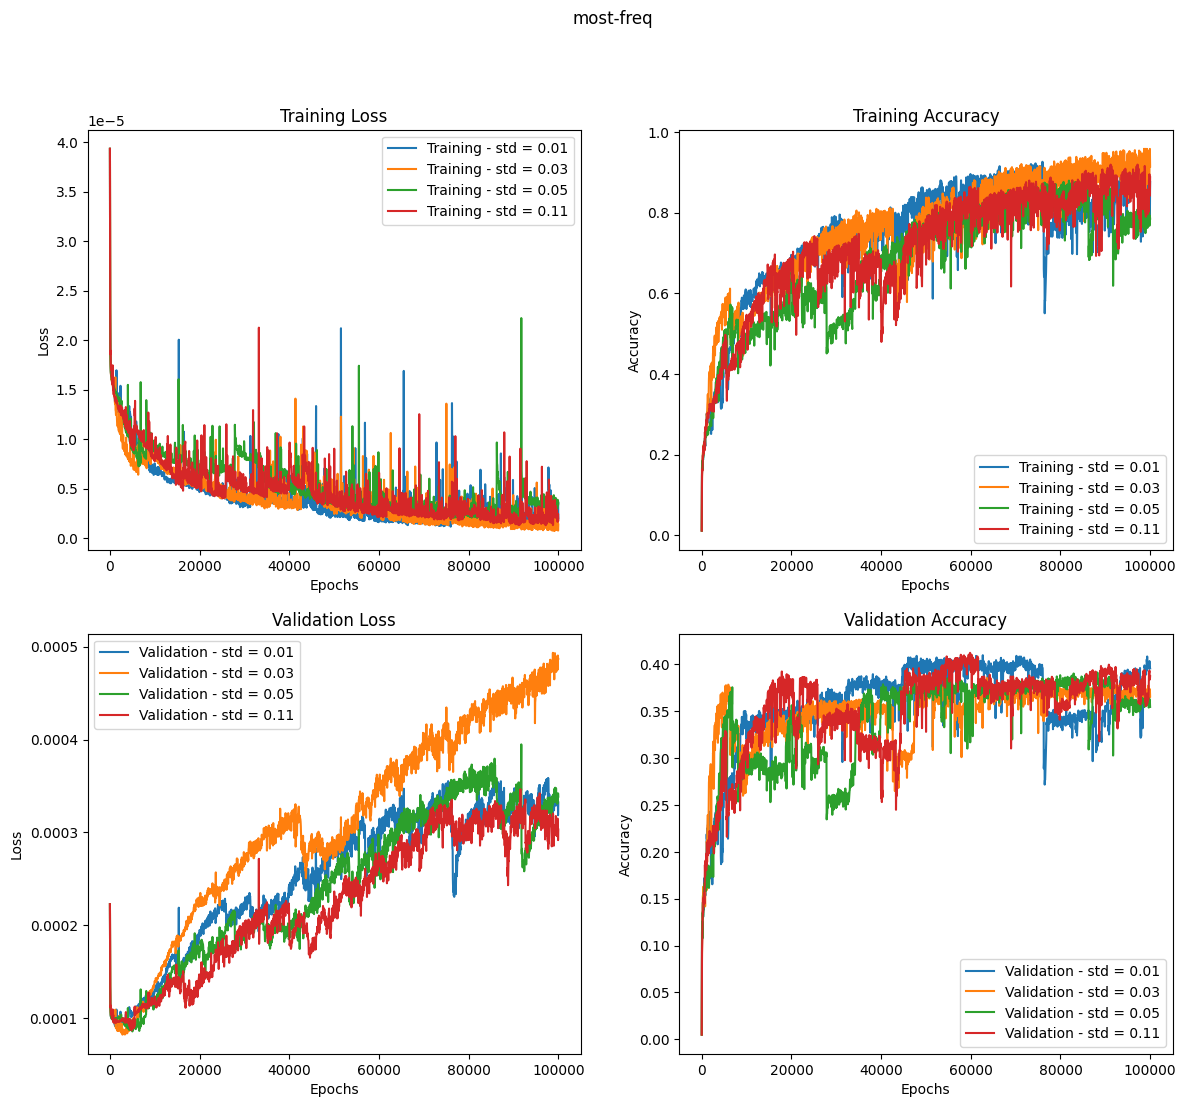

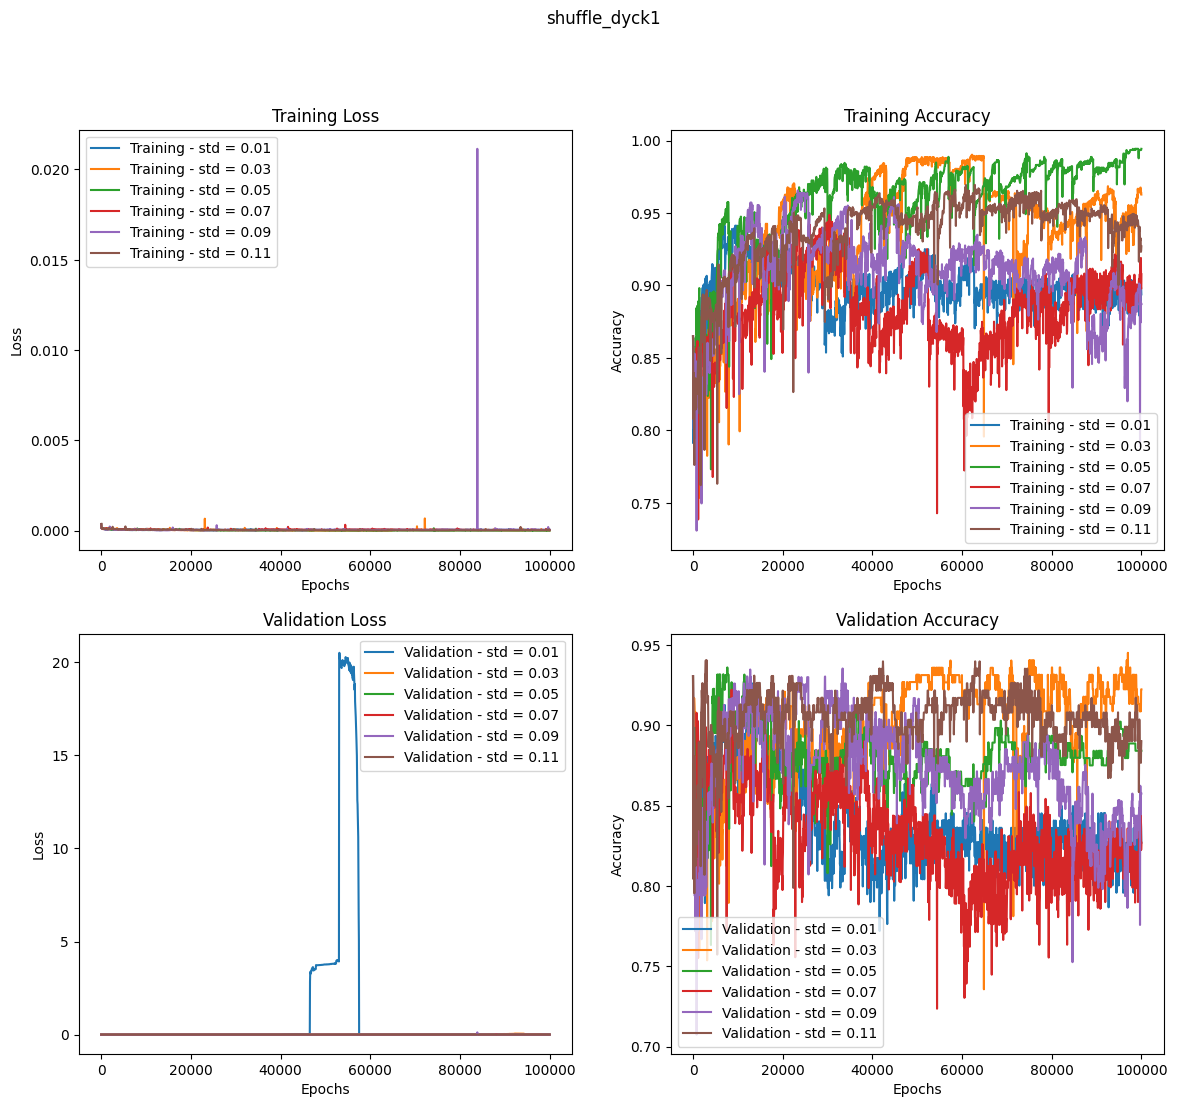

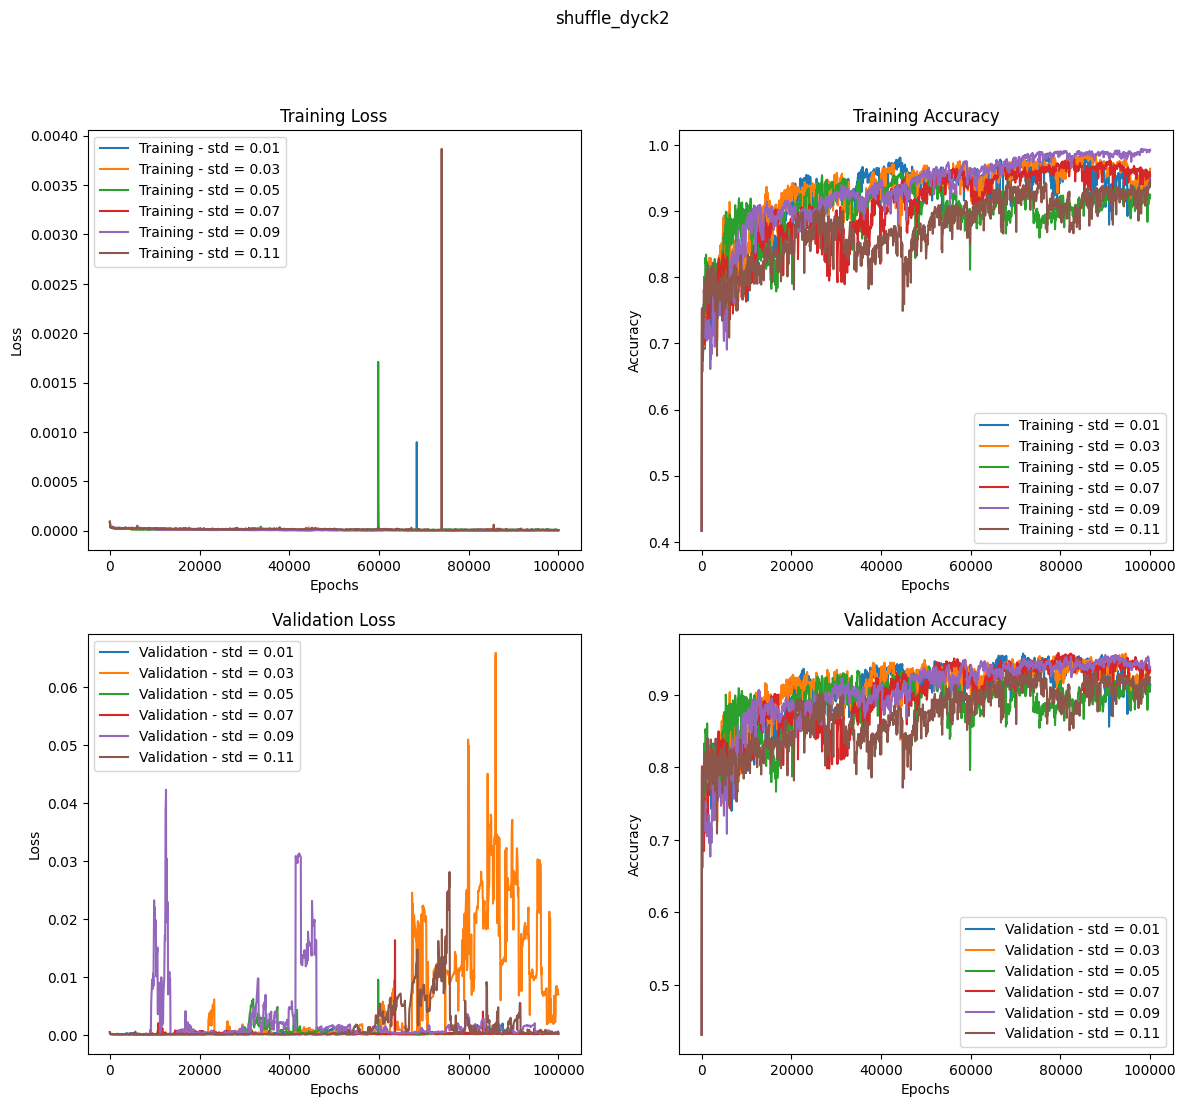

In [13]:
baseDirectory = os.path.abspath(os.path.join('../..')) + "/PerformanceTesting/savedData/noiseTrainingGaussian/"
stdMode = None
displayResults(baseDirectory, "sort", consideredParams = [0.01, 0.03, 0.05, 0.07, 0.09, 0.11], stdMode=stdMode, useLogLoss=False)
displayResults(baseDirectory, "reverse", consideredParams = [0.01, 0.05, 0.09, 0.11], stdMode=stdMode, useLogLoss=False) #Files might exist but are saved with incorect data
displayResults(baseDirectory, "hist", consideredParams = [0.01, 0.03, 0.05, 0.07, 0.09, 0.11], stdMode=stdMode, useLogLoss=False)
displayResults(baseDirectory, "most-freq", consideredParams = [0.01, 0.03, 0.05, 0.11], stdMode=stdMode, useLogLoss=False) #Files don't exist
displayResults(baseDirectory, "shuffle_dyck1", consideredParams = [0.01, 0.03, 0.05, 0.07, 0.09, 0.11], stdMode=stdMode, useLogLoss=False)
displayResults(baseDirectory, "shuffle_dyck2", consideredParams = [0.01, 0.03, 0.05, 0.07, 0.09, 0.11], stdMode=stdMode, useLogLoss=False)

### Displaying Gaussian noise results up till std 1.25

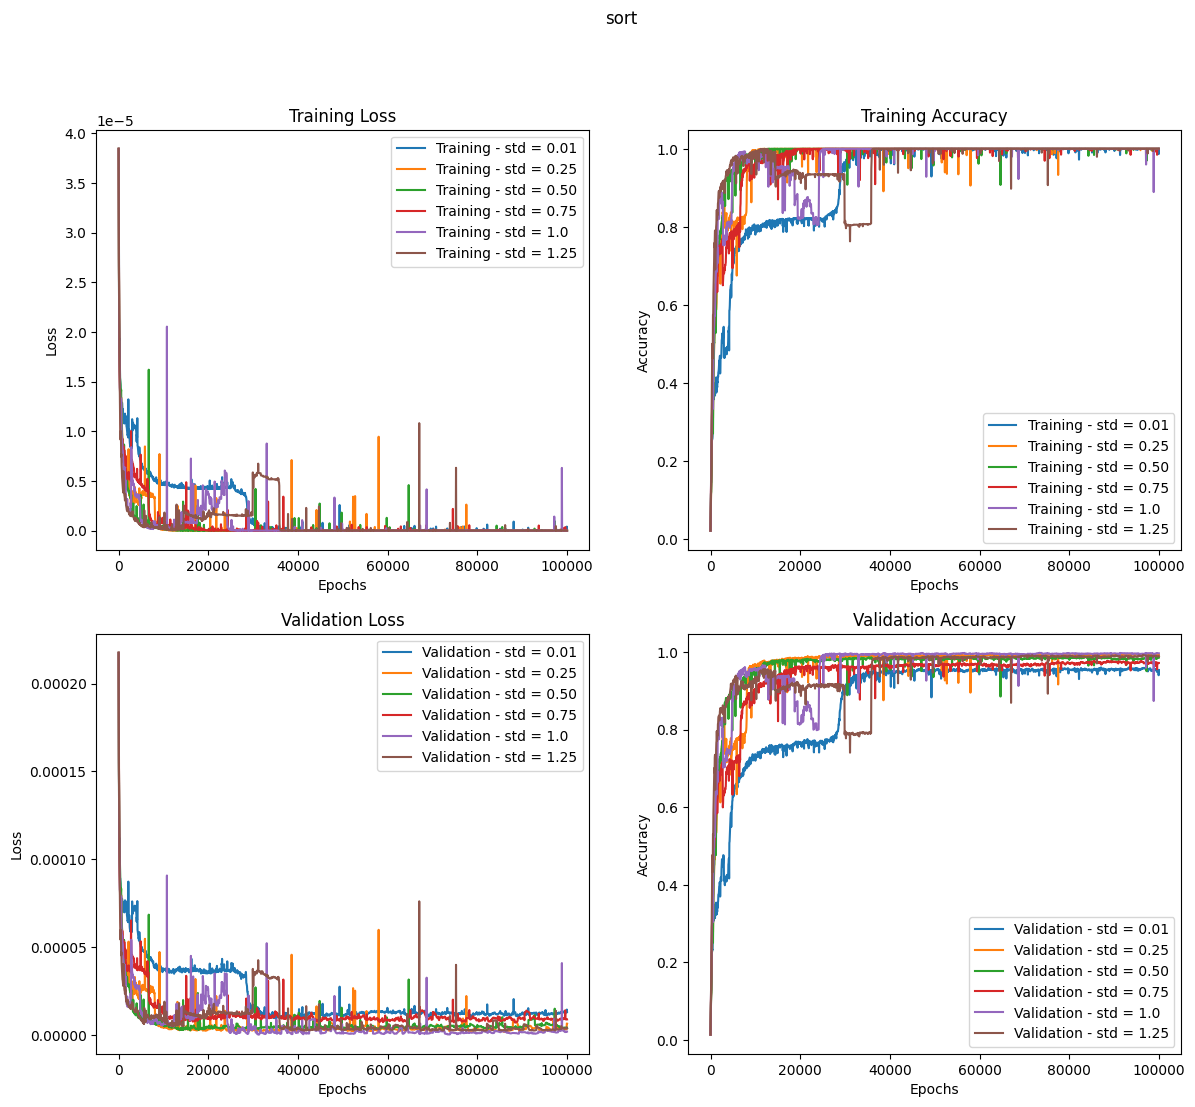

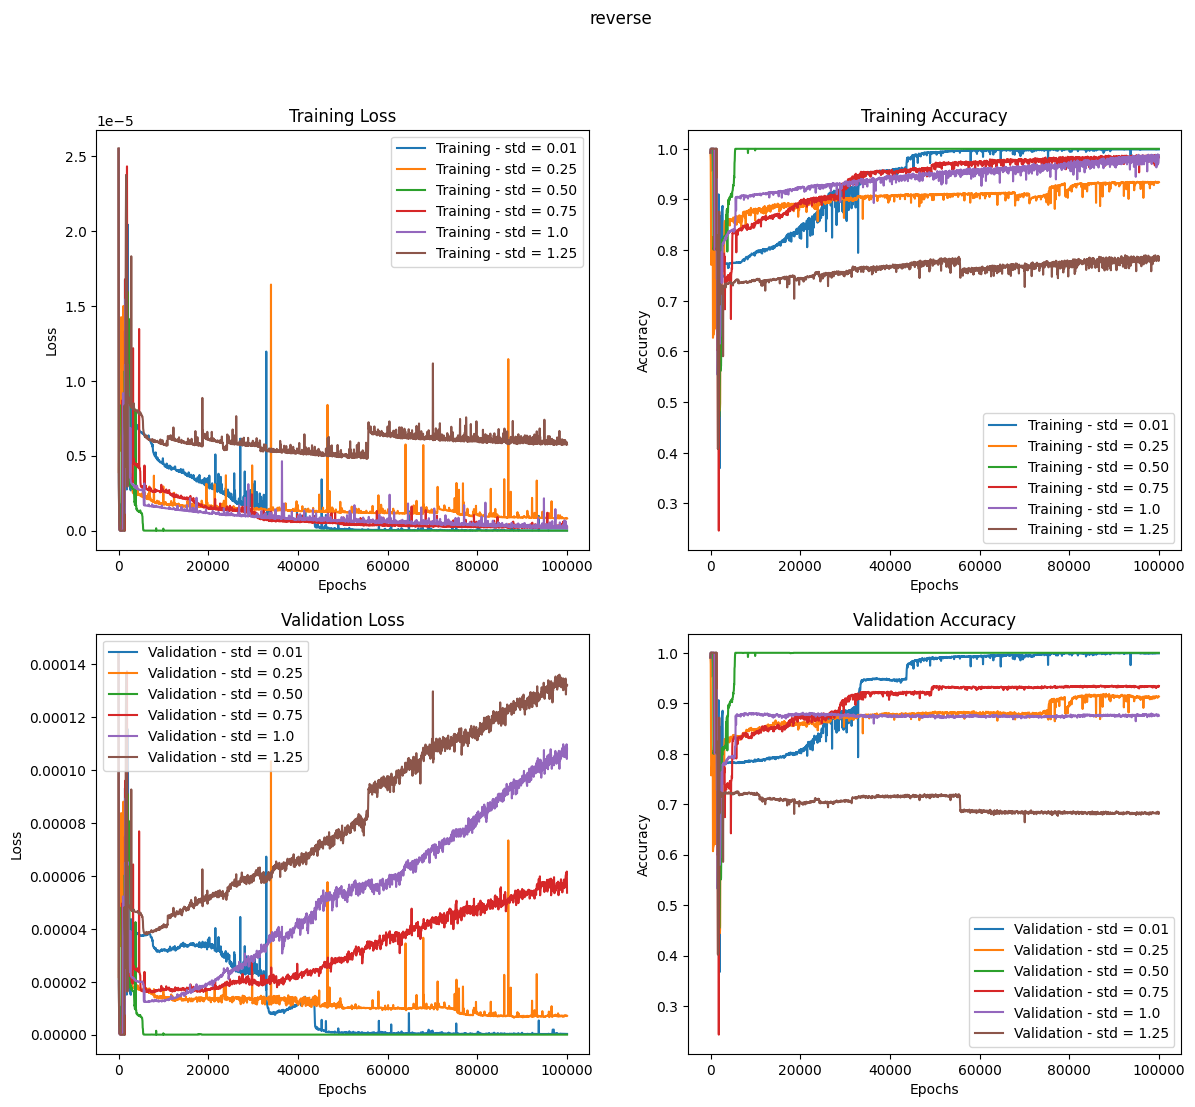

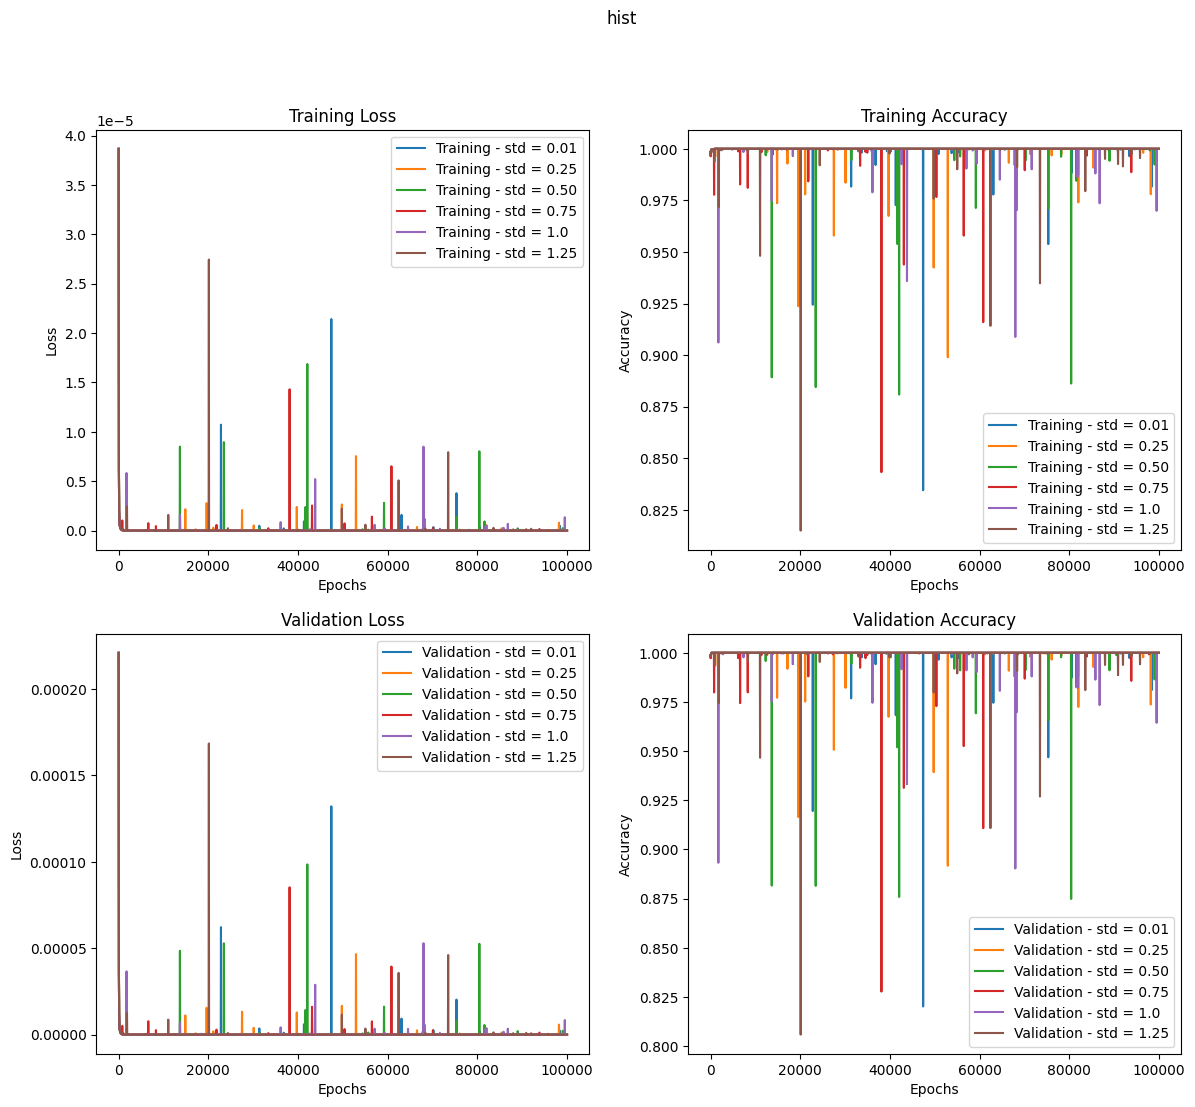

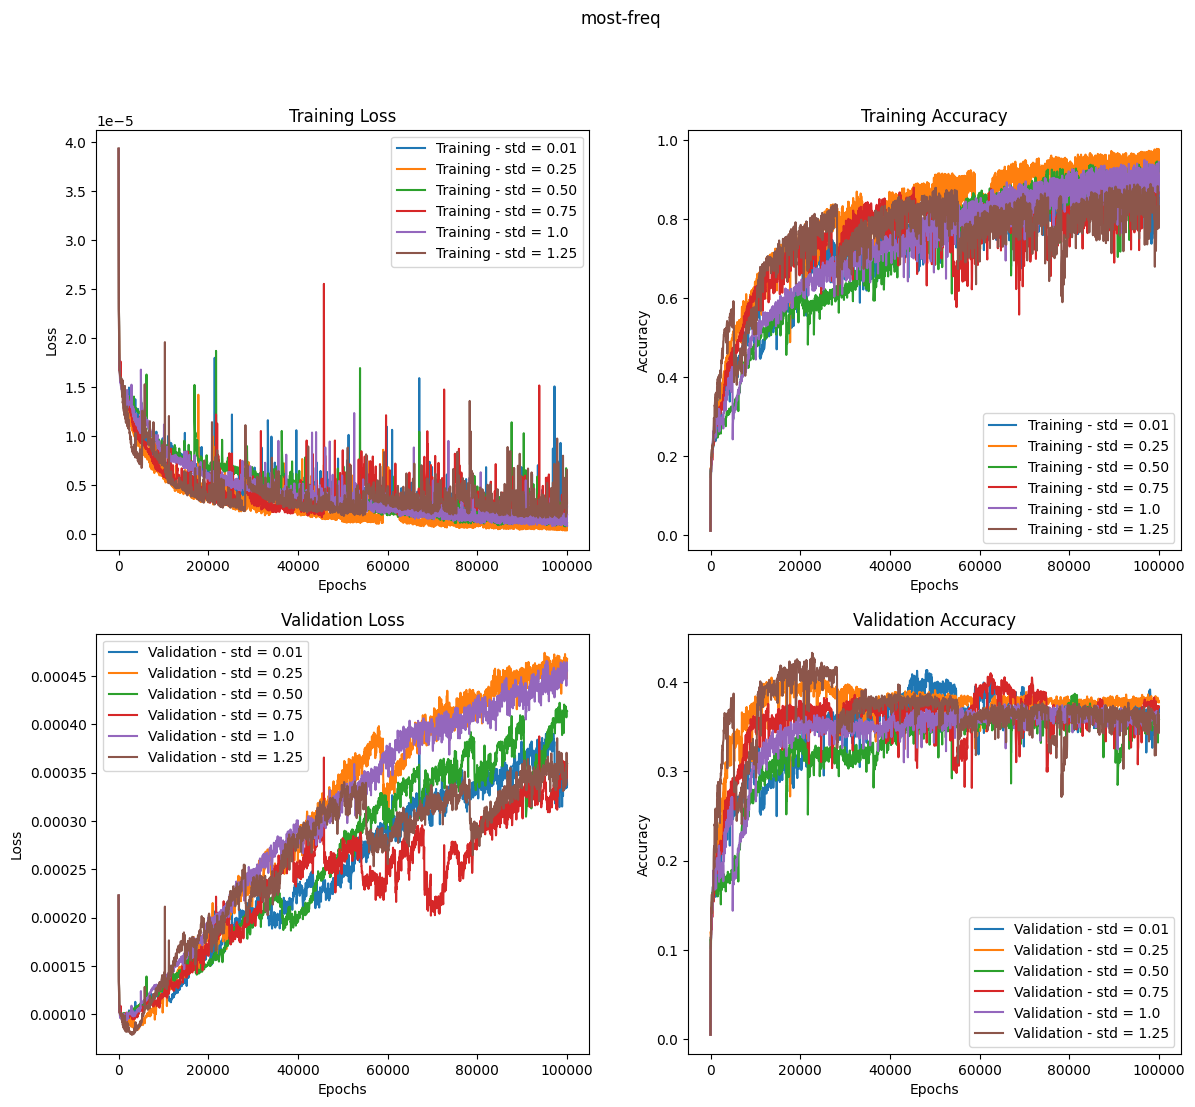

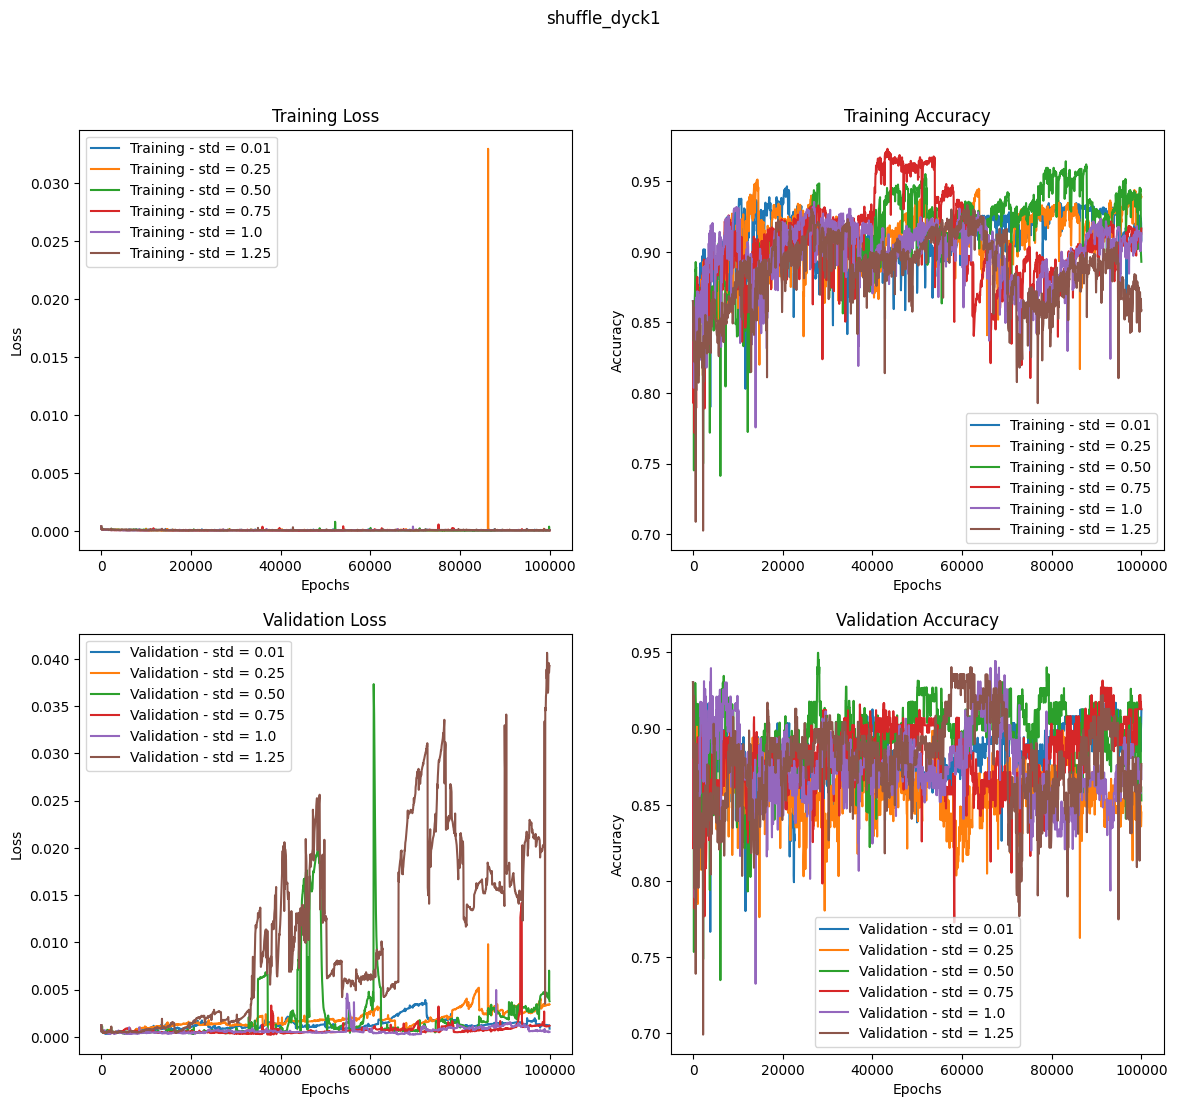

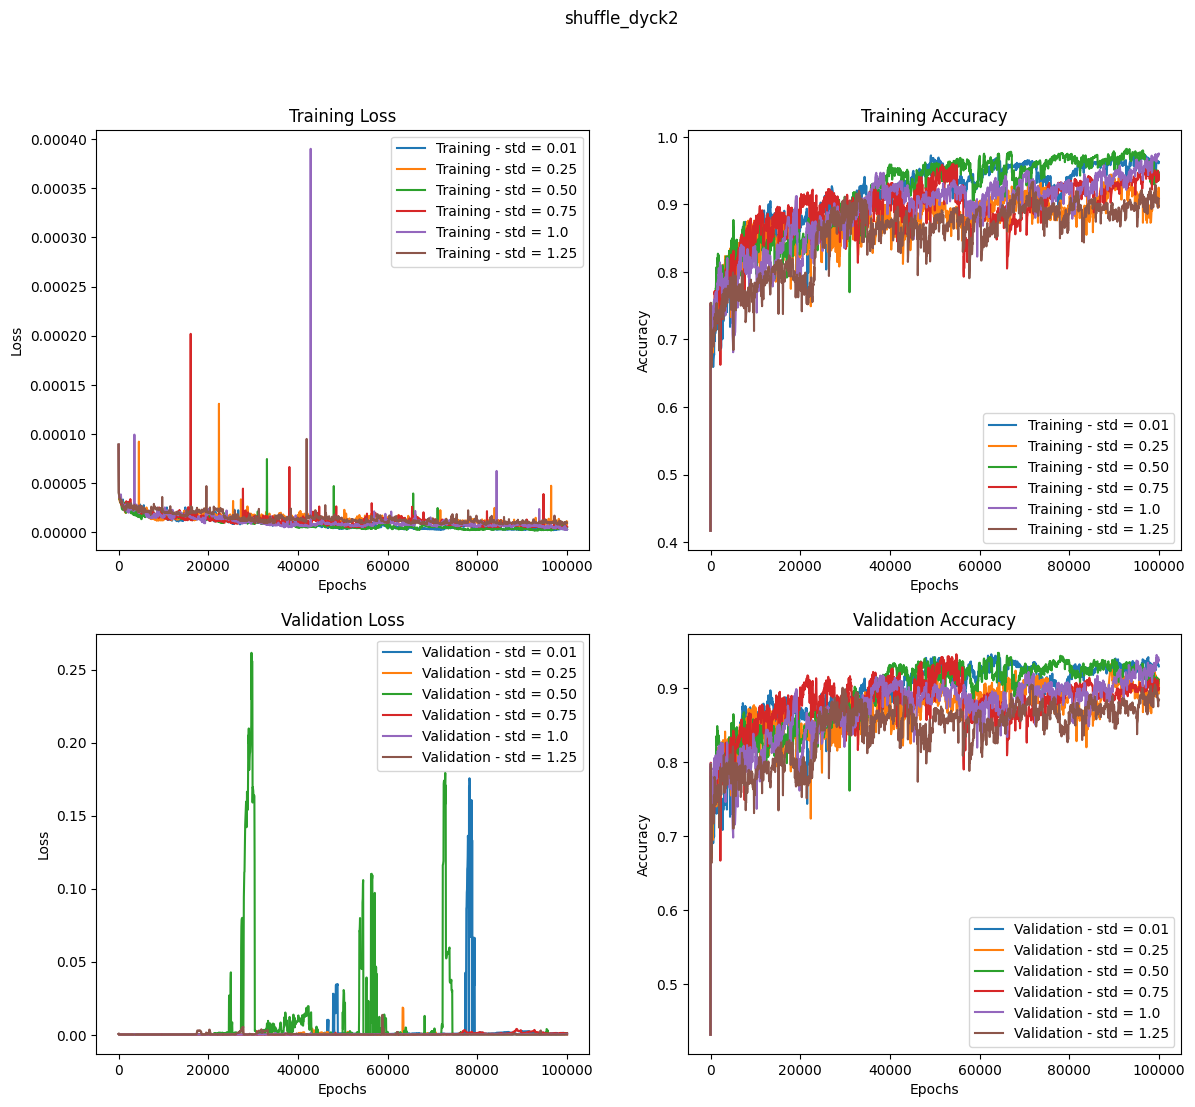

In [16]:
baseDirectory = os.path.abspath(os.path.join('../..')) + "/PerformanceTesting/savedData/noiseTrainingGaussian2/"
stdMode = None
displayResults(baseDirectory, "sort", consideredParams = ["0.01", "0.25", "0.50", "0.75", "1.0", "1.25"], stdMode=stdMode, useLogLoss=False)
displayResults(baseDirectory, "reverse", consideredParams = ["0.01", "0.25", "0.50", "0.75", "1.0", "1.25"], stdMode=stdMode, useLogLoss=False)
displayResults(baseDirectory, "hist", consideredParams = ["0.01", "0.25", "0.50", "0.75", "1.0", "1.25"], stdMode=stdMode, useLogLoss=False)
displayResults(baseDirectory, "most-freq", consideredParams = ["0.01", "0.25", "0.50", "0.75", "1.0", "1.25"], stdMode=stdMode, useLogLoss=False):
displayResults(baseDirectory, "shuffle_dyck1", consideredParams = ["0.01", "0.25", "0.50", "0.75", "1.0", "1.25"], stdMode=stdMode, useLogLoss=False)
displayResults(baseDirectory, "shuffle_dyck2", consideredParams = ["0.01", "0.25", "0.50", "0.75", "1.0", "1.25"], stdMode=stdMode, useLogLoss=False)

### Tracking down the failed runs

In [14]:
import os


def getFileNames(baseDirectory, modelName, setAndMetric, noiseType, fileParamName, paramValue, averageCount):
    fileNames = []
    for i in range(1,averageCount+1):
        fileNames.append(baseDirectory + modelName + setAndMetric + noiseType + fileParamName + str(paramValue) + "_" + str(i))
    return fileNames

def listMissingGaussianFiles(baseDirectory, consideredValues = [0.01, 0.03, 0.05, 0.07, 0.09, 0.11], consideredModels = ["sort", "reverse", "hist", "most-freq", "shuffle_dyck1", "shuffle_dyck2"]):
    presentFiles = os.listdir(baseDirectory)
    for i in range(len(presentFiles)):
        presentFiles[i] = presentFiles[i].split("/")[-1]

    noiseType = "gaussian"
    fileParamName = "_std"

    for modelName in consideredModels:
        for dataSet in ["val", "train"]:
            for metric in ["acc", "loss"]:
                setAndMetric = "_" + dataSet + "_" + metric + "_"
                for value in consideredValues:
                    for fileName in getFileNames(baseDirectory, modelName, setAndMetric, noiseType, fileParamName, value, 5):
                        fileName = fileName.split("/")[-1]
                        if fileName in presentFiles:
                            pass
                        else:
                            print(fileName)

baseDirectory = os.path.abspath(os.path.join('../..')) + "/PerformanceTesting/savedData/noiseTrainingGaussian/"
listMissingGaussianFiles(baseDirectory)

reverse_val_acc_gaussian_std0.07_5
reverse_val_loss_gaussian_std0.07_5
reverse_train_acc_gaussian_std0.07_5
reverse_train_loss_gaussian_std0.07_5
most-freq_val_acc_gaussian_std0.07_5
most-freq_val_acc_gaussian_std0.09_4
most-freq_val_loss_gaussian_std0.07_5
most-freq_val_loss_gaussian_std0.09_4
most-freq_train_acc_gaussian_std0.07_5
most-freq_train_acc_gaussian_std0.09_4
most-freq_train_loss_gaussian_std0.07_5
most-freq_train_loss_gaussian_std0.09_4


19, 169, 173

In [15]:
baseDirectory = os.path.abspath(os.path.join('../..')) + "/PerformanceTesting/savedData/noiseTrainingGaussian2/"
listMissingGaussianFiles(baseDirectory, consideredValues=["0.01", "0.25", "0.50", "0.75", "1.0", "1.25"])